# Radial Velocities

In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from maelstrom.kepler import kepler

/Users/dforeman/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Read in the light curve, the frequencies, and then the RV data.

In [3]:
# kicid = 6780873
kicid = 8975515

times, dmag = np.loadtxt(f"data/kic{kicid}_lc.txt",usecols=(0,1)).T

# Subtract midpoint
time_mid = (times[0] + times[-1]) / 2.
times -= time_mid

# mmags
dmmags = dmag * 1000. 

metadata = np.loadtxt(f"data/kic{kicid}_metadata.csv", delimiter=",", skiprows=1)
nu_arr = metadata[::6]

In [4]:
# load the RV data. They have the same time format (JD-2400000) as the light curve.
# rvs are in the format [[JD, RV, uncertainty]]
rv_JD, rv_RV, rv_err = np.loadtxt(f"data/kic{kicid}a_JDrv.txt",delimiter=",", usecols=(0,1,2)).T
rv_JD -= time_mid

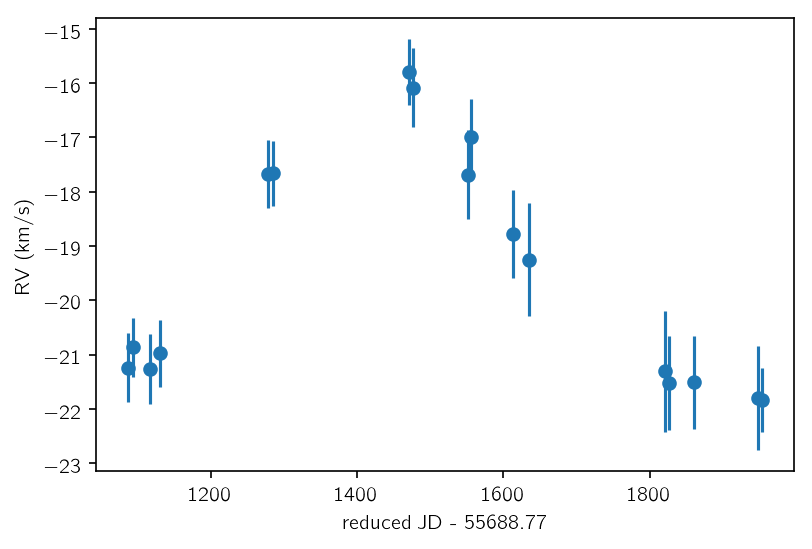

In [5]:
# plot just the RVs for now
plt.errorbar(rv_JD,rv_RV,rv_err,fmt="o")
plt.xlabel(f"reduced JD - {np.round(time_mid,2)}")
plt.ylabel("RV (km/s)")
plt.show()

In [6]:
# read in the table of orbits
orbits = pd.read_csv(f"data/orbits.csv").rename(columns = lambda x: x.strip())

# oops, our target doesn't have an orbit there, since P < 20 days.
# let's just cheat a bit for now and read in the orbit of this one target as the orbits db
# orbits = pd.read_csv(f"data/kic{kicid}_orbit.csv").rename(columns = lambda x: x.strip())

orb_params = orbits[orbits.Name == f"kic{kicid}"].iloc[0]
# initialising close to a better solution
porb = 1088. #orb_params.Porb
a1 = 138. #orb_params["a1sini/c"]
tp = 55087.218038 - time_mid #orb_params["t_p"] - time_mid
e = 0.12 #orb_params["e"]
varpi = 3.764 #orb_params["varpi"]
a1d = a1/86400.0
e_param = np.log(e) - np.log(1.0 - e)

In [7]:
sess = tf.InteractiveSession()

In [20]:
T = tf.float64

# First the variables that we might want to optimize:
porb_tensor = tf.Variable(porb, dtype=T)
a1d_tensor = tf.Variable(a1d, dtype=T)
tp_tensor = tf.Variable(tp, dtype=T)
nu_tensor = tf.Variable(nu_arr, dtype=T)
e_param_tensor = tf.Variable(e_param, dtype=T)  # This forces the ecc to be between 0 and 1
e_tensor = 1.0 / (1.0 + tf.exp(-e_param_tensor))
varpi_tensor = tf.Variable(varpi, dtype=T)
log_sigma2_tensor = tf.Variable(0.0, dtype=T)  # Variance from observational uncertainties and model misspecification
log_rv_sigma2_tensor = tf.Variable(np.log(np.median(rv_err)), dtype=T)  # RV jitter
gammav_tensor = tf.Variable(np.mean(rv_RV) / 299792.458, dtype=T)

# These are some placeholders for the data:
times_tensor = tf.placeholder(T, times.shape)
dmmags_tensor = tf.placeholder(T, dmmags.shape)

# Solve Kepler's equation
mean_anom = 2.0 * np.pi * (times_tensor - tp_tensor) / porb_tensor
ecc_anom = kepler(mean_anom, e_tensor)
true_anom = 2.0 * tf.atan2(tf.sqrt(1.0+e_tensor)*tf.tan(0.5*ecc_anom),tf.sqrt(1.0-e_tensor) + tf.zeros_like(times_tensor))

Calculate the model and likelihood for the time delays

In [37]:
# Here we define how the time delay will be calculated:
tau_tensor = -a1d_tensor * (1.0 - tf.square(e_tensor)) * tf.sin(true_anom + varpi_tensor) / (1.0 + e_tensor*tf.cos(true_anom))

# And the design matrix:
arg_tensor = 2.0 * np.pi * nu_tensor[None, :] * (times_tensor - tau_tensor)[:, None]
D_tensor = tf.concat([tf.cos(arg_tensor), tf.sin(arg_tensor)], axis=1)

# Define the linear solve for W_hat:
DTD_tensor = tf.matmul(D_tensor, D_tensor, transpose_a=True)
DTy_tensor = tf.matmul(D_tensor, dmmags_tensor[:, None], transpose_a=True)
W_hat_tensor = tf.linalg.solve(DTD_tensor, DTy_tensor)

# Finally, the model and the chi^2 objective:
model_tensor = tf.squeeze(tf.matmul(D_tensor, W_hat_tensor))
chi2_tensor = tf.reduce_sum(tf.square(dmmags_tensor - model_tensor)) * tf.exp(-log_sigma2_tensor)
chi2_tensor += len(times) * log_sigma2_tensor

# NOW THE RVs:
rv_time_tensor = tf.placeholder(T)
rv_tensor = tf.placeholder(T)
rv_err_tensor = tf.placeholder(T)

# Solve Kepler's equation for the RVs
rv_mean_anom = (2.0 * np.pi * (rv_time_tensor - tp_tensor) / porb_tensor)
rv_ecc_anom = kepler(rv_mean_anom, e_tensor)
rv_true_anom = 2.0 * tf.atan2(tf.sqrt(1.0+e_tensor)*tf.tan(0.5*rv_ecc_anom), tf.sqrt(1.0-e_tensor) + tf.zeros_like(rv_time_tensor))

# Here we define how the RV will be calculated:
vrad_tensor = -2.0 * np.pi * (a1d_tensor / porb_tensor) * (1/tf.sqrt(1.0 - tf.square(e_tensor))) * (tf.cos(rv_true_anom + varpi_tensor) + e_tensor*tf.cos(varpi_tensor))
vrad_tensor += gammav_tensor
vrad_tensor *= 299792.458  # c in km/s

rv_sig2 = tf.square(rv_err_tensor) + tf.exp(log_rv_sigma2_tensor)
chi = tf.square(rv_tensor - vrad_tensor) / rv_sig2 + tf.log(rv_sig2)
chi2_tensor += tf.reduce_sum(chi)

var_list = [
    porb_tensor, a1d_tensor, tp_tensor, e_param_tensor, varpi_tensor, log_rv_sigma2_tensor, log_sigma2_tensor, gammav_tensor
]

init = tf.global_variables_initializer()
sess.run(init)

In [38]:
feed_dict = {
    times_tensor: times,
    dmmags_tensor: dmmags,
    rv_time_tensor: rv_JD,
    rv_tensor: rv_RV,
    rv_err_tensor: rv_err,
}

sess.run(chi2_tensor, feed_dict=feed_dict)

9837.538819340145

In [39]:
sess.run(tf.gradients(chi2_tensor, var_list), feed_dict=feed_dict)

[0.20273284277836284,
 480.58088801180054,
 0.09662450555809338,
 1.3610389099390836,
 -14.735472910394341,
 6.616604783997744,
 55484.884683744516,
 462590.3845323924]

In [40]:
for v in var_list[::-1]:
    opt = tf.contrib.opt.ScipyOptimizerInterface(chi2_tensor, var_list=[v])
    opt.minimize(sess, feed_dict=feed_dict)

opt = tf.contrib.opt.ScipyOptimizerInterface(chi2_tensor, var_list=var_list[1:])
for i in range(3):
    opt.minimize(sess, feed_dict=feed_dict)
opt = tf.contrib.opt.ScipyOptimizerInterface(chi2_tensor, var_list=var_list)
for i in range(3):
    opt.minimize(sess, feed_dict=feed_dict)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 9837.495161
  Number of iterations: 2
  Number of functions evaluations: 4
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -58376.778723
  Number of iterations: 7
  Number of functions evaluations: 9
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -58383.980974
  Number of iterations: 16
  Number of functions evaluations: 17
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -58384.497290
  Number of iterations: 3
  Number of functions evaluations: 5
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -58386.72

In [41]:
sess.run(chi2_tensor, feed_dict=feed_dict)

-58387.29607366857

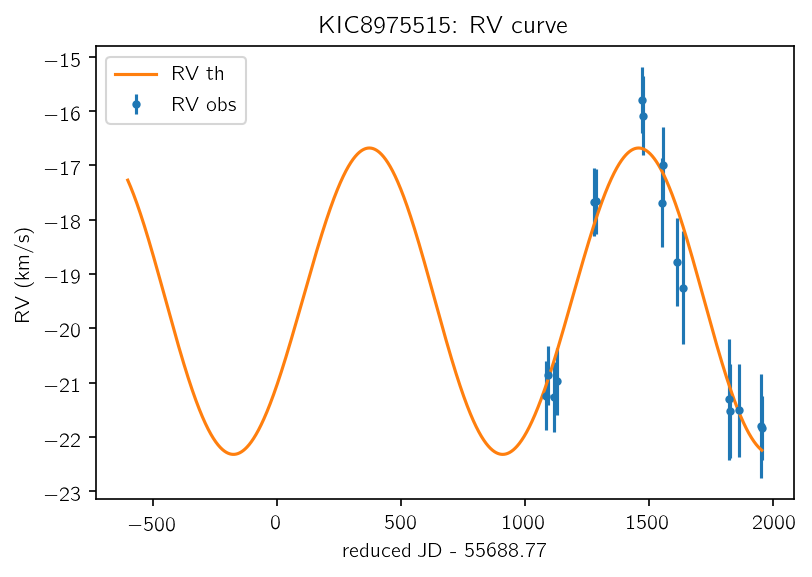

In [42]:
rv_time_test = np.sort(np.linspace(sess.run(tp_tensor), rv_JD.max(), 5000))
vrad_test = sess.run(vrad_tensor, feed_dict={rv_time_tensor: rv_time_test})

plt.errorbar(rv_JD,rv_RV,rv_err,fmt=".",label='RV obs')
plt.plot(rv_time_test, vrad_test,label='RV th')
plt.xlabel(f"reduced JD - {np.round(time_mid,2)}")
plt.ylabel("RV (km/s)")
plt.title("KIC"+str(kicid) + ": RV curve")
plt.legend()
plt.show()

In [43]:
rv_JD.max() - rv_JD.min(), sess.run(porb_tensor)

(867.8088500000013, 1084.3633717172581)

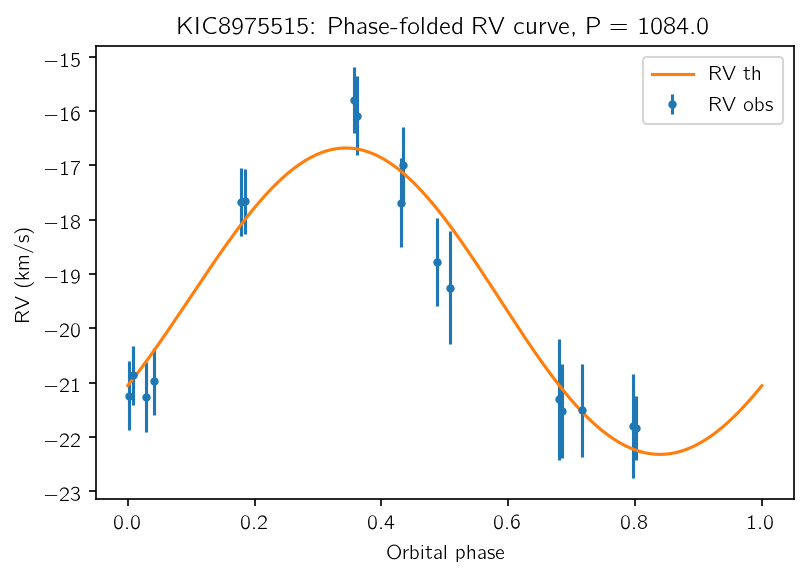

In [44]:
rv_phi_test = np.sort(np.linspace(0, sess.run(porb_tensor), 5000) % sess.run(porb_tensor))
vrad_test = sess.run(vrad_tensor, feed_dict={rv_time_tensor: rv_phi_test})

plt.errorbar((rv_JD % sess.run(porb_tensor))/sess.run(porb_tensor),rv_RV,rv_err,fmt=".",label='RV obs')
plt.plot(rv_phi_test/sess.run(porb_tensor), vrad_test,label='RV th')
plt.xlabel("Orbital phase")
plt.ylabel("RV (km/s)")
plt.title("KIC"+str(kicid) + ": Phase-folded RV curve, P = " + f"{np.round(sess.run(porb_tensor))}")
plt.legend()
plt.show()

In [45]:
print(time_mid)
print(sess.run(tp_tensor))
print(rv_JD)

55688.769671949995
-600.0984862940143
[1085.86185805 1092.81977805 1115.92200805 1129.82251805 1277.57670805
 1284.67761805 1470.81226805 1475.85645805 1550.93996805 1555.81603805
 1612.74272805 1634.64100805 1820.94800805 1826.89865805 1860.75902805
 1948.72222805 1953.67070805]


In [46]:
sess.run(gammav_tensor)*299792.458

-19.529358722870903

In [47]:
sess.run(var_list, feed_dict=feed_dict)

[1084.3633717172581,
 0.0016241241003276488,
 -600.0984862940143,
 -4.404830582863855,
 3.801425397323375,
 -11.421929038991104,
 -1.8939439133778964,
 -6.514292872194571e-05]

In [48]:
print(f"e = {np.round(sess.run(e_tensor),3)}")
print(f"a1sini/c = {np.round(sess.run(a1d_tensor)*86400.,3)} s")

e = 0.012
a1sini/c = 140.324 s
